In [1]:
from utils.imports import *

passengers, drivers, adj, nodes = initialize_data(True)
edited_passengers = pd.read_pickle('data/edited_passengers.pkl')
edited_drivers = pd.read_pickle('data/edited_drivers.pkl')

# B1

In [58]:
#calculate numbers of passenger in every clustering range and rename them as pCnt
#And we normalize them to get range 0-1
edited_passengers = pd.read_pickle('data/edited_passengers.pkl')
nodes_label = pd.read_pickle('data/nodes_label.pkl')

pCnt = [0 for i in range(0,70)]
for i in edited_passengers:
    plabel = nodes_label[i[1]]
    pCnt[plabel] = pCnt[plabel]+1
pCnt = np.array(pCnt)
pCnt = pCnt/(pCnt.max()+pCnt.min())


In [95]:
def binary_search(drivers, time):#Dichotomy search for the mid closest to time

    left, mid, right = 0, 0, len(drivers) - 1
    
    while left <= right:
        mid = (left + right)//2
        if drivers[mid][0] < time:
            left = mid + 1
        elif drivers[mid][0] > time:
            right = mid - 1
        else:
            break
    
    return mid

def find_driver3(passenger, drivers, nodes, adj, find_path):
    eligible_point = binary_search(drivers, passenger[0])
    passenger_node = passenger[1]
    
    if drivers[eligible_point][0] > passenger[0]:
        eligible_point -= 1
    
    closest_node = None
    closest_dist = float('inf')
    for i in range(eligible_point + 1):
        driver_node = drivers[i][1]
                 
        cap = get_edge_num(drivers[i][2], drivers[i][3])
        dist = find_path(driver_node, passenger[1], adj, nodes, cap)
        
        if dist < closest_dist:
            closest_dist = dist
            closest_node = (drivers[i], i)
    
    return closest_node
#If the total number of passengers in the area is large, priority will be given to assigning drivers
#Defined here as the reciprocal after normalization of pCnt

def find_driverb1(passenger, drivers, nodes, adj, find_path):
    nodes_label = pd.read_pickle('data/nodes_label.pkl')
    node_dists = pd.read_pickle('data/node_dists.pkl')
    #The more people in the area where the passenger is located, the driver of the farther node will be assigned
    #Aim to make the drivers in this area become more 
    closest_node = None
    closest_dist = float('inf')
    passenger_node = passenger[1]    
    passenger_label = nodes_label[passenger_node]
    ratio = pCnt[passenger_label]#Increase with the rise of numbers of people
    driverList = []
    for i in range(len(drivers)):
        driver = drivers[i]
        driver_node = driver[1]
        
        dist = node_dists[(nodes_label[driver_node], nodes_label[passenger_node])]
        closest_dist = dist
        closest_node = (closest_dist, driver, i) 
        driverList.append(closest_node)
        
    driverList = sorted(driverList)
    driverList = driverList[:int(len(driver)*ratio+1)]
    closest_node = driverList[len(driverList)//2]
    return (closest_node[1],closest_node[2])
            

In [96]:
res_cus, res_driv, res_time = match(fast_get_closest_node, find_driverb1, astar)

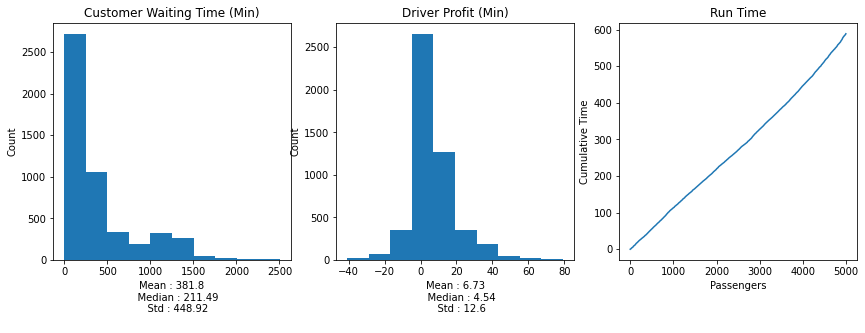

In [97]:
process_results(res_cus, res_driv, res_time)

# B2

In [2]:
state_info = {0.3:{}, 0:{}}


In [69]:
def find_driverb2(passenger, drivers, nodes, adj, find_path, slower_ratio = 0):
    nodes_label = pd.read_pickle('data/nodes_label.pkl')
    node_dists = pd.read_pickle('data/node_dists.pkl')
    
    closest_node = None
    closest_dist = float('inf')
    passenger_node = passenger[1]
    
    for i in range(len(drivers)):
        driver = drivers[i]
        driver_node = driver[1]
        driver_id = driver[-1]
        
        #if driver_id is not in the slower_ratio then this driver have 1 as slower_ratio
        if driver_id not in state_info[slower_ratio]:
            state_info[slower_ratio][driver_id] = 1
        
        if driver[0] > passenger[0]:
            #if driver is later than passenger then slower_ratio = 1
            state_info[slower_ratio][driver_id] += 1
            return closest_node
        #If the time is greater than the time of the passenger, the greater the weight of the driver's time, the farther the distance during sorting, and the harder it is to receive the previous order
        #To help drivers who are ahead of passenger time better receive orders
        ratio = 1 + state_info[slower_ratio][driver_id] * slower_ratio
        dist = node_dists[(nodes_label[driver_node], nodes_label[passenger_node])] * ratio + ratio
        
        if dist < closest_dist:
            closest_dist = dist
            closest_node = (driver, i)
        
        if dist == 0:
            state_info[slower_ratio][driver_id] += 1
            return closest_node

In [70]:
res_cus, res_driv, res_time = match(fast_get_closest_node, find_driverb2, astar)

KeyboardInterrupt: 

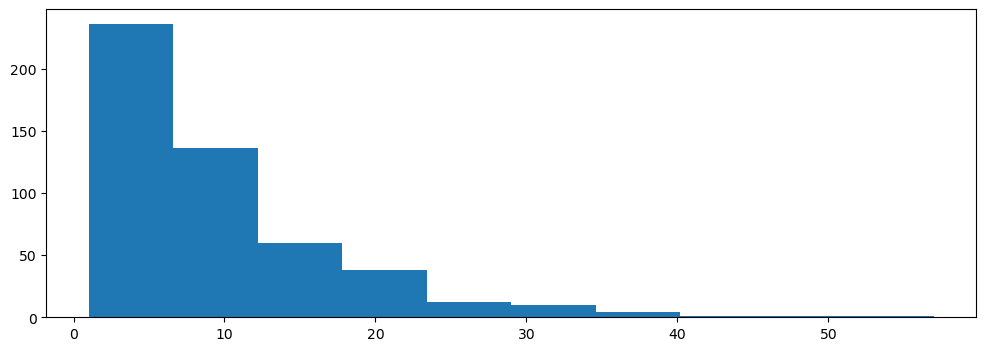

9.366733466933868

In [ ]:
plt.hist(list(state_info[0.3].values()))
plt.show()
values = np.array(list(state_info[0.3].values()))
values.mean()

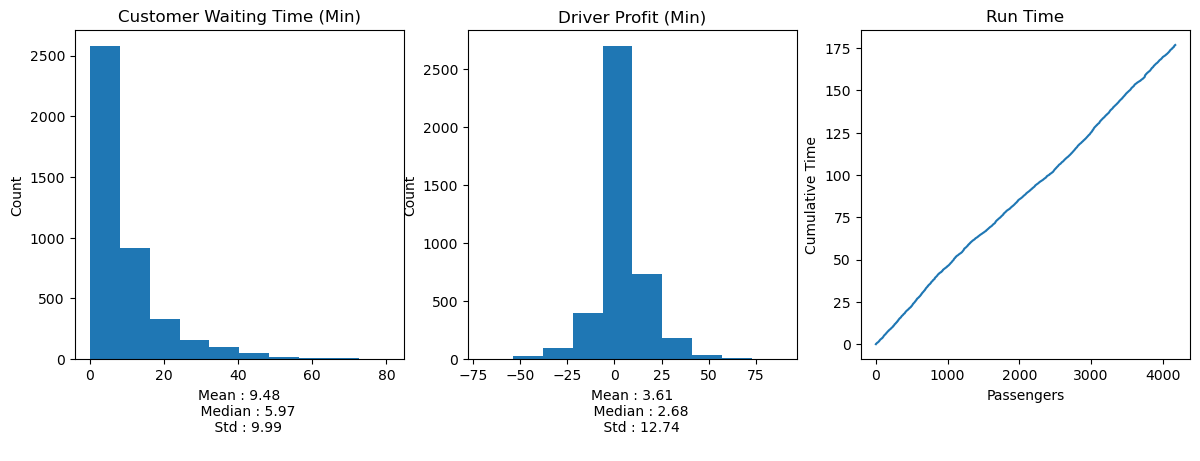

In [ ]:
process_results(res_cus, res_driv, res_time)

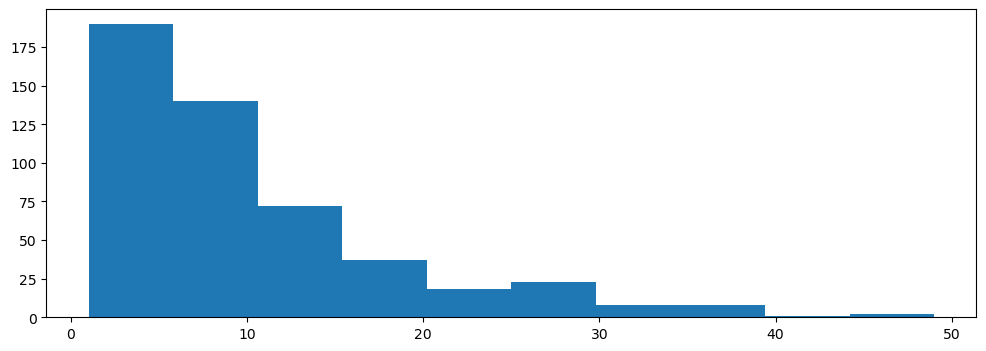

10.08817635270541

In [ ]:
plt.hist(list(state_info[0].values()))
plt.show()
values = np.array(list(state_info[0].values()))
values.mean()

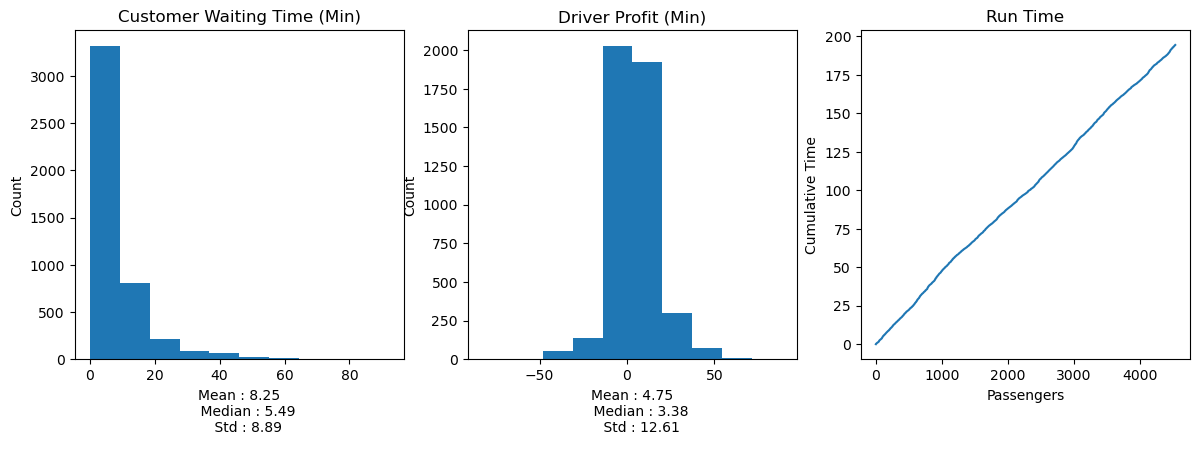

In [ ]:
process_results(res_cus, res_driv, res_time)

In [ ]:
state_info[0] = {}

# B3

In [2]:
"""
1. Dijkstra algorithm calculates all paths of previously excluded vehicles
2. Choose a slightly farther road as the new route
3. Determine whether the current congestion time is
4. If it is a congested time, choose a slightly distant but non congested route
Algorithm implementation: Based on the Dijktra algorithm, intercept the nodes in the 1st/nth segment
The value of n is set according to the situation
Use this as an intermediate node to calculate the shortest path for the front and rear segments respectively.
"""

'\n1、Dijkstra算法计算前面排除车辆的所有路径\n2、选取稍远的一条路作为新路线\n3、判断当前是否为拥堵时间\n4、如果是拥堵时间，则选择稍远但是不拥堵的路线\n\n算法实现：在Dijktra算法的基础上，截取第1/n段的节点\nn的值视情况设定\n以此为中间节点分别对前后段进行最短路径计算。\n'

In [3]:
def binary_search(drivers, time):#Dichotomy search for the mid closest to time

    left, mid, right = 0, 0, len(drivers) - 1
    
    while left <= right:
        mid = (left + right)//2
        if drivers[mid][0] < time:
            left = mid + 1
        elif drivers[mid][0] > time:
            right = mid - 1
        else:
            break
    
    return mid

def find_driver2(passenger, drivers, nodes, adj, find_path):
    #find the driver with the least time
    eligible_point = binary_search(drivers, passenger[0])
    
    if drivers[eligible_point][0] > passenger[0]:
        eligible_point -= 1
    
    passenger_node = passenger[1]
    
    closest_node = None
    closest_dist = float('inf')
    
    #find the nearest driver
    for i in range(eligible_point + 1):
        driver_node = drivers[i][1]
        euclid = (nodes[driver_node]['lon'] - nodes[passenger_node]['lon'])**2
        euclid += (nodes[driver_node]['lat'] - nodes[passenger_node]['lat'])**2
        #calculate the euclid distance
        if euclid < closest_dist:
            closest_dist = euclid
            closest_node = (drivers[i], i)
    
    return closest_node

In [4]:
#Dijkstra algorithm that can return paths
def dijkstra_new(start, target, adj, nodes, cap, init = True):
    dist, pq = {}, []
    if init:
        dist, pq = pd.read_pickle('data/init_search.pkl')
        dist[start] = 0
        heapq.heappush(pq, (dist[start], start))
    else:
        for node in nodes:
            dist[node] = float('inf')
        dist[start] = 0
        for node in dist:
            heapq.heappush(pq, (dist[node], node))
    path  = []

    while len(pq):
        distance, node = heapq.heappop(pq)
        for neighbor in adj[node]:
            times = distance + adj[node][neighbor][0]/adj[node][neighbor][cap]
            if dist[neighbor] > times:
                dist[neighbor] = times
                path.append(neighbor)
                heapq.heappush(pq, (dist[neighbor], neighbor))

            if neighbor == target:
                return (dist[neighbor] * 60), path
    return -1
#find the shorter path
def second_short_path(start, target, adj, nodes, cap,init = True):# the second-short path
    s1,p1 = dijkstra_new(start, target, adj, nodes, cap, init = True)
    n=6#adjustable n, bigger n means closer to the shortest path
    midNode = p1[len(p1)//n]
    result1, path1 = dijkstra_new(start, midNode, adj, nodes, cap, init = True)
    result2, path2 = dijkstra_new(midNode,target, adj, nodes, cap, init = True)
    
    return result2+result1
    

In [5]:
res_cus, res_driv, res_time = match(slow_get_closest_node, find_driver2, second_short_path)

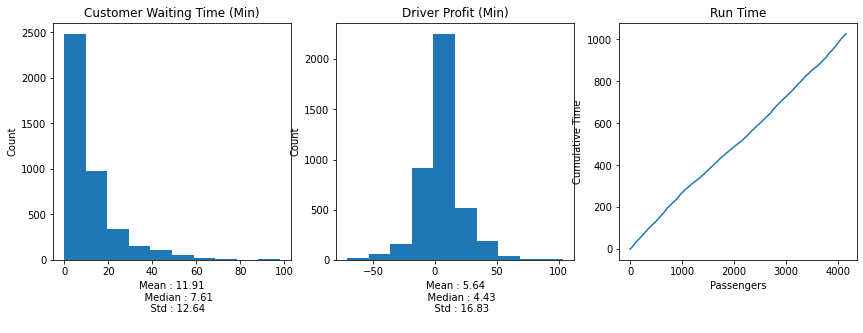

In [6]:
process_results(res_cus, res_driv, res_time)

# B4

In [7]:
from utils.imports import *

Count the number of passengers at each time
Count the number of drivers at each time
Node with the highest number of passengers counted
Node with the Most Destinations in Statistics
Visualize the nodes with the highest number of passengers and destinations


In [8]:
df1 = pd.read_csv('passengers.csv')
df1.columns = ['datetime', 'source_lat', 'source_lom', 'dest_lat', 'dest_lon']
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['source_node'] = pd.DataFrame(edited_passengers)[1]
df1['dest_node'] = pd.DataFrame(edited_passengers)[2]

df1['hour'] = df1.datetime.dt.hour
df1['weekend'] = df1.datetime.dt.day_of_week > 4

df2 = pd.read_csv('drivers.csv')
df2.columns = ['datetime', 'source_lat', 'source_lon']
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['node'] = pd.DataFrame(edited_drivers)[1]
df2['hour'] = df2.datetime.dt.hour
df2['weekend'] = df2.datetime.dt.day_of_week > 4


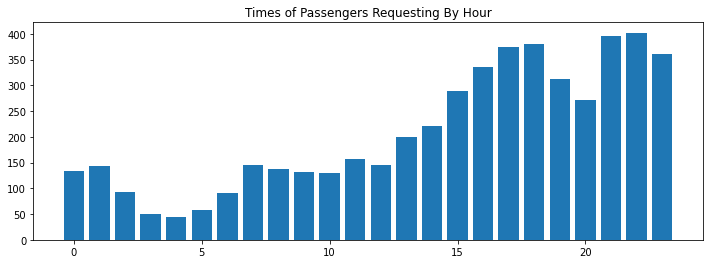

In [9]:
#Count the number of passengers at each time
plt.bar(x = np.arange(0, 24), height = df1.groupby('hour')['datetime'].count())
plt.title('Times of Passengers Requesting By Hour')
plt.show()

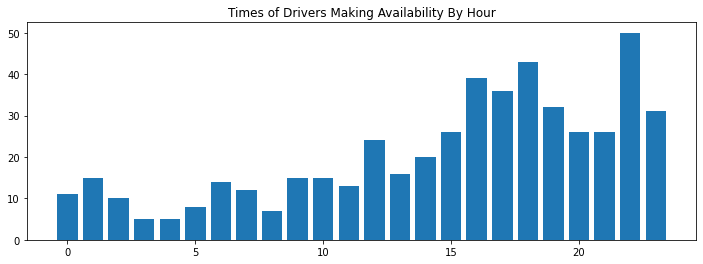

In [10]:
#Count the number of drivers at each time
plt.bar(x = np.arange(0, 24), height = df2.groupby('hour')['datetime'].count())
plt.title('Times of Drivers Making Availability By Hour')
plt.show()

In [11]:
#
df2.groupby('node')['datetime'].count().sort_values()

node
42421737      1
42455200      1
42454997      1
42454994      1
42454742      1
             ..
42430384      3
42435910      3
42443561      4
42444909      4
1698103521    5
Name: datetime, Length: 443, dtype: int64

In [12]:
#Node with the highest number of passengers counted
src_nodes = df1.groupby('source_node')[['datetime']].count().sort_values(by = 'datetime', ascending = False).reset_index()
src_nodes.columns = ['source_node', 'times']
src_nodes.iloc[0:10].style.set_caption("Most Common Source Nodes")  

,source_node,times
0,4633522237,33
1,42444909,22
2,1698103521,18
3,246649427,18
4,4557517555,16
5,42429633,15
6,42430384,15
7,42445953,13
8,42429412,13
9,42435596,13


In [13]:
#Node with the Most Destinations in Statistics
dest_nodes = df1.groupby('dest_node')[['datetime']].count().sort_values(by = 'datetime', ascending = False).reset_index()
dest_nodes.columns = ['dest_node', 'times']
dest_nodes.iloc[0:10].style.set_caption("Most Common Dest Nodes")  

,dest_node,times
0,1698103521,39
1,4633522237,33
2,4059141532,21
3,1701651380,20
4,599041406,20
5,42435642,17
6,42429412,15
7,42430384,14
8,2087152389,13
9,4443775465,13


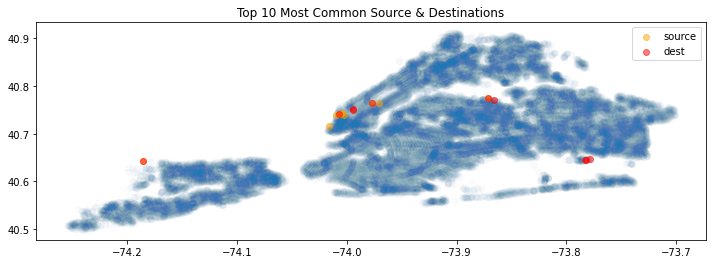

In [14]:
#Visualize the nodes with the highest number of passengers and destinations
nodes_df = pd.DataFrame(nodes).T.reset_index()
nodes_df.columns = ['node', 'lon', 'lat']

dest_nodes_df = nodes_df.loc[nodes_df['node'].isin(dest_nodes.iloc[0:10]['dest_node'])]
src_nodes_df = nodes_df.loc[nodes_df['node'].isin(src_nodes.iloc[0:10]['source_node'])]

plt.scatter(nodes_df['lon'], nodes_df['lat'], alpha = 0.01)
plt.scatter(src_nodes_df['lon'], src_nodes_df['lat'], alpha = 0.5, color = 'orange', label = 'source')
plt.scatter(dest_nodes_df['lon'], dest_nodes_df['lat'], alpha = 0.5, color = 'red', label = 'dest')
plt.legend()
plt.title("Top 10 Most Common Source & Destinations")
plt.show()